# Homework 7

In this homework, you will be using a form of attention called *attention pooling* to solve the "addition problem". The addition problem was introduced in the [LSTM paper](https://www.bioinf.jku.at/publications/older/2604.pdf) as a way to test whether an RNN could propagate information across many time steps. In the addition problem, the model is given a sequence of 2D vectors in the format:

|     |      |     |     |      |     |      |     |     |     |     |
|-----|------|-----|-----|------|-----|------|-----|-----|-----|-----|
| 0.5 | -0.7 | 0.3 | 0.1 | -0.2 | ... | -0.5 | 0.9 | ... | 0.8 | 0.2 |
| 0   |   0  |  1  |  0  |   0  |     |   0  |  1  |     |  0  |  0  |

The first dimension of each vector in the sequence is a random number between 0 and 1. The second dimension is 0 for all entries of the sequence expect for 2, where it is 1. The goal of the addition problem is to output the sum of the values in the first dimension at the two indices where the second dimension is 1. In the example above, the target would be 0.9 + 0.3 = 1.2. Below is a code snippet which generates a sequence and its target for the addition problem.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
def addition_problem(sequence_length=50):
    output = np.random.uniform(-1, 1, (sequence_length, 2))
    output[:, 0] = 0.
    random_indices = np.random.choice(sequence_length, size=2, replace=False)
    output[random_indices, [0, 0]] = 1
    return output, (output[:, 0]*output[:, 1]).sum(keepdims=True)

Attention pooling is a form of attention that allows a model to solve the addition problem without using an RNN. In attention pooling, the query vector $q$ is a *learnable parameter*. The keys and values are both the input sequence. Specifically, given a sequence $\{h_1, h_2, \ldots, h_T\}$, attention pooling computes
\begin{align}
e_t &= \mathrm{a}(q, h_t) \\
\alpha_t &= \frac{\exp(e_t)}{\sum_k \exp(e_k)} \\
c &= \sum_{t = 1}^T \alpha_t h_t
\end{align}
where $\mathrm{a}(q, h_t)$ is the attention energy function. Note that c will always be a fixed-length vector (which amounts to a weighted average of the elements of the sequence $h$) regardless of how long the sequence is (i.e. the value of $T$). $\mathrm{a}(q, h_t)$ can be any function that takes in a single entry of the sequence $h_t$ and outputs an unnormalizes scalar value. One option is to use
$$\mathrm{a}(q, h_t) = q^\top \tanh(W_a h_t + b_a)$$
where $q \in \mathbb{R}^q$, $W_a \in \mathbb{R}^{q \times d}$, and $b_a \in \mathbb{R}^q$ are learnable parameters, and $d$ is the dimensionality of $h_t$ (i.e. $h_t \in \mathbb{R}^d$).


1. Build and train a neural network that uses attention pooling to solve the addition problem. The model should output a scalar which corresponds to the target value for the addition problem (i.e. the sum of the sequence entries that are marked with a "1"). Here, "solved" means that the squared error of the model's predicitons is always below $0.05$. Use a sequence length of $50$ (which is the default for the `addition_problem` function defined above). *Hints*:
  1. This is a regression problem. Your model should predict a continuous scalar value and you can use a squared-error loss.
  1. The point of the attention pooling layer is to allow you to put it in an otherwise feed-forward network. So, consider just using simple dense feed-forward layers before and/or after the attention pooling layer. To start, you can try the architecture: feed-forward, attention pooling, feed-forward, output layer.
  1. If you are finding that the model is getting stuck at a non-zero squared error, it could be that it's just outputting the mean value and having trouble learning a good solution. Try different initialization, nonlinearities, architecture, learning rate, etc.
1. Once you have trained a model that gets solid performance at sequence length $50$, plot the model's average squared error for sequence lengths $50, 55, 65, 80, 100, 125, 150$. You should generate this plot by averaging the squared error over at least $100$ sequences of a given length. Does the model's error get worse (go up) for longer sequences, or does it generalize to longer sequence lengths?

1. It's common to represent a batch of sequences as an array of shape (batch_size, sequence_length, n_features).
2.  position-wise feedforward layer (like the ones we discussed in the Transformer) are dense layers that are applied independently to each sequence step for each sequence in the batch. Specifically, you can think of it as computing output[i, j] = dot(W, input[i, j]) + b, where input is of shape (batch_size, sequence_length, n_input) and output is of shape (batch_size, sequence_length, n_output), i indexes the batch dimension, and j indexes the sequence timestep.
3. If your dense layer assumes that the input is of shape (batch_size, n_input), you reshape the input to (batch_size*sequence_length, n_input), feed it through the dense layer, and reshape the result back to shape (batch_size, sequence_length, n_output). This is because either way you are applying the dense layer independently to each vector in each sequence.
4. The network architecture I suggested is something like dense -> attention pooling -> dense. You can experiment with different network architectures.
5. The point of the attention pooling is to transform an input from shape (batch_size, sequence_length, n_features) to (batch_size, n_features). This is done by taking a (weighted) average over the sequence length dimension. Once you perform this transformation, you get a single vector for each input example in the batch, regardless of the sequence length. This allows you to compute a single loss for each example in the batch.



In [ ]:
import torch
from torch.autograd import Variable
import torch.nn.functional as F
import torch.utils.data as Data

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

def addition_problem(sequence_length=50):
    output = np.random.uniform(-1, 1, (sequence_length, 2))
    output[:, 0] = 0.
    random_indices = np.random.choice(sequence_length, size=2, replace=False)
    output[random_indices, [0, 0]] = 1
    return torch.tensor(output), torch.tensor((output[:, 0]*output[:, 1]).sum(keepdims=True))


In [ ]:
def addition_with_batch(sequence_length=50): # size = 4
  len = sequence_length
  x1, y1 = addition_problem(len)
  x2, y2 = addition_problem(len)
  x3, y3 = addition_problem(len)
  x4, y4 = addition_problem(len)

  xx = torch.cat((x1,x2,x3,x4)).reshape(4, len, 2).float()
  yy = torch.cat((y1,y2,y3,y4)).reshape(4, 1).float()
  return xx, yy
x, y = addition_with_batch(50)

In [ ]:
# this is one way to define a network
class Net(torch.nn.Module):
    def __init__(self, d, q, n_hidden, n_output): # d = 2, q = 10, 10 ,1
        super(Net, self).__init__()
        self.d = d
        self.q = q
        self.n_hidden = n_hidden
        self.hidden1 = torch.nn.Linear(d,n_hidden)
        self.w = torch.nn.Linear(n_hidden,q)
        self.query = torch.nn.Parameter(torch.zeros(q,1))
        #self.register_parameter(name='query', param=torch.nn.Parameter(torch.zeros(q,1)))
        self.tanh = torch.nn.Tanh()
        self.hidden2 = torch.nn.Linear(d, n_hidden)   # hidden layer
        self.predict = torch.nn.Linear(n_hidden, n_output)   # output layer

    def forward(self, x,):
        keys = x
        values = x

        # hidden 1
        x = x.reshape(-1,self.d)
        x = F.relu(self.hidden1(x))      # activation function for hidden layer
        x = x.reshape(4,-1,self.n_hidden)

        # attention
        x = x.reshape(-1,self.n_hidden)
        x = self.w(x)
        x = self.tanh(x)
        x = torch.matmul(x,self.query)
        x = x.reshape(4,-1)
        x = torch.nn.functional.softmax(x,dim = 1) # 4*50
        x = x.reshape(4,1,-1) # 4*1*50
        # value's size is 4*50*2
        x = torch.bmm(x,values).reshape(4,2)

        # hidden 2
        x = F.relu(self.hidden2(x))      # activation function for hidden layer
        x = self.predict(x)             # linear output
        return x


In [ ]:
net = Net(d=2, q=10, n_hidden=10, n_output=1)     # define the network
print(net)  # net architecture
optimizer = torch.optim.Adam(net.parameters(), lr=0.01)
loss_func = torch.nn.MSELoss()  # this is for regression mean squared loss

Net(
  (hidden1): Linear(in_features=2, out_features=10, bias=True)
  (w): Linear(in_features=10, out_features=10, bias=True)
  (tanh): Tanh()
  (hidden2): Linear(in_features=2, out_features=10, bias=True)
  (predict): Linear(in_features=10, out_features=1, bias=True)
)


In [ ]:
prediction = net(x)     # input x and predict based on x

loss = loss_func(prediction, y)     # must be (1. nn output, 2. target)
loss

tensor(1.2809, grad_fn=<MseLossBackward>)

In [ ]:
# train the network
for t in range(2000):
    x, y = addition_with_batch()
    prediction = net(x)     # input x and predict based on x

    loss = loss_func(prediction, y)     # must be (1. nn output, 2. target)

    optimizer.zero_grad()   # clear gradients for next train
    loss.backward()         # backpropagation, compute gradients
    optimizer.step()        # apply gradients
    if(t%200 == 0):
      print(loss)

tensor(0.0609, grad_fn=<MseLossBackward>)
tensor(0.0004, grad_fn=<MseLossBackward>)
tensor(7.6854e-05, grad_fn=<MseLossBackward>)
tensor(3.5542e-05, grad_fn=<MseLossBackward>)
tensor(1.5260e-05, grad_fn=<MseLossBackward>)
tensor(3.1213e-06, grad_fn=<MseLossBackward>)
tensor(2.2107e-06, grad_fn=<MseLossBackward>)
tensor(2.2950e-06, grad_fn=<MseLossBackward>)
tensor(3.9795e-06, grad_fn=<MseLossBackward>)
tensor(1.4647e-06, grad_fn=<MseLossBackward>)


In [ ]:
x, y = addition_with_batch()
prediction = net(x.float())
print(y)
print(prediction)

tensor([[ 1.3133],
        [-1.6394],
        [ 0.6015],
        [-0.7667]])
tensor([[ 1.3139],
        [-1.6392],
        [ 0.5988],
        [-0.7665]], grad_fn=<AddmmBackward>)


Once you have trained a model that gets solid performance at sequence length  50 , plot the model's average squared error for sequence lengths  50,55,65,80,100,125,150 . You should generate this plot by averaging the squared error over at least  100  sequences of a given length. Does the model's error get worse (go up) for longer sequences, or does it generalize to longer sequence lengths?


In [ ]:
def compute_loss(net,sequence_len,batch_num): # num is num_batch * 4
  total_loss = 0
  for i in np.arange(batch_num):
    x,y = addition_with_batch(sequence_len)
    prediction = net(x)
    loss = loss_func(prediction, y)
    total_loss = total_loss + loss
  return total_loss / batch_num



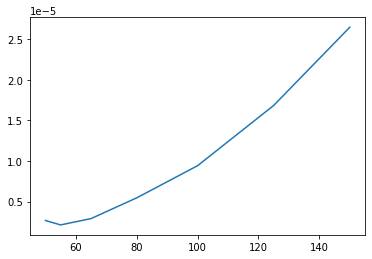

In [ ]:
x_axis = [50,55,65,80,100,125,150]
y_axis = []
for i in x_axis:
  y_axis.append(compute_loss(net,i,100))
plt.plot(x_axis,y_axis)

In [ ]:
# In this case, the model's error gets larger as the sequence length gets larger,
# but it's also possible to train a model that generalizes well to longer sequences.